In [30]:
import yfinance as yf
import pandas as pd
import numpy as np
import random
import math
import statistics
from collections import namedtuple, deque, Counter
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
top_8_tech = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'META', 'TSLA', 'TSM']
top_4_tech = ['AAPL', 'MSFT', 'GOOG', 'AMZN']

used_tech = top_4_tech

In [5]:
# run this to download the data 
datas = {}
num_shares = {}
for ticker in used_tech:
    data = yf.Ticker(ticker)
    df = data.history(period="5y", interval='1d')
    datas[ticker] = df
    df.to_csv(f"data/stocksv1/{ticker}.csv")
    
    num_shares[ticker] = int(data.info['marketCap']/data.info['previousClose'])

In [3]:
# run this to load the data wo re-downloading
datas = {}
num_shares = {}

for ticker in used_tech:
    datas[ticker] = pd.read_csv(f"data/stocksv1/{ticker}.csv").set_index('Date')
    data = yf.Ticker(ticker)
    
    # Note: This will break if there are any stock splits between the last time the data was downloaded
    # and the time the num shares is computed. Redownload data if this happens
    num_shares[ticker] = int(data.info['marketCap']/data.info['previousClose'])

([<matplotlib.axis.XTick at 0x7fa5602978b0>,
 [Text(0, 0, '2018-05-10 00:00:00-04:00'),
  Text(1258, 0, '2023-05-09 00:00:00-04:00')])

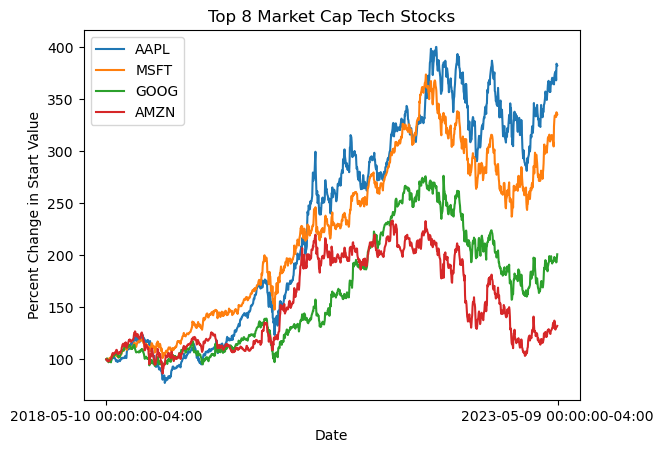

In [4]:
for ticker in used_tech:
    stval = datas[ticker]['High'][0]
    datas[ticker]['High'].apply(lambda x: 100*x/stval).plot()
plt.legend(top_4_tech)
plt.ylabel("Percent Change in Start Value")
plt.title("Top 8 Market Cap Tech Stocks")
plt.xticks([0, len(datas[ticker]-1)], [datas[ticker].index[0], datas[ticker].index[-1]], rotation=0)

In [28]:
datas['AAPL']

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-05-10 00:00:00-04:00,44.744125,45.370932,44.722673,45.292282,111957200,0.0000,0.0
2018-05-11 00:00:00-04:00,45.335352,45.471722,44.847282,45.120026,104848800,0.1825,0.0
2018-05-14 00:00:00-04:00,45.220510,45.344920,44.945375,45.014755,83115200,0.0000,0.0
2018-05-15 00:00:00-04:00,44.686984,44.756369,44.285047,44.605640,94780800,0.0000,0.0
2018-05-16 00:00:00-04:00,44.517114,45.088920,44.500365,45.021927,76732400,0.0000,0.0
...,...,...,...,...,...,...,...
2023-05-03 00:00:00-04:00,169.500000,170.919998,167.160004,167.449997,65136000,0.0000,0.0
2023-05-04 00:00:00-04:00,164.889999,167.039993,164.309998,165.789993,81235400,0.0000,0.0
2023-05-05 00:00:00-04:00,170.979996,174.300003,170.759995,173.570007,113316400,0.0000,0.0


# Problem Setup

We have downloaded 5 years of daily stock data for the top 8 market cap tech stocks. We are going to see if we can devise a trading strategy using deep q learning to trade between these stocks every day. Our actions will be taken every day at open, where we will be able to buy any distribution of the top 8 market cap tech stocks that we want. We will then sell all at the close. Devising a trading strategy that holds overnight will be an exercise for the future. 

### Data Splits 

The naieve approach would be to use the first 3 years as training, 4th year as validation, and 5th as testing. This approach may have some downsides as 2022 markets may behave completley differently than 2020 markets. As a result, the data split will be a 60/20/20 split of every year.  

### Evaluation

To evaluate our model, we will buy a market capped weighted combination of the stocks at open and sell at close. This would be the equivalent of a index representing the top 8 tech stocks that is re-weighted daily (discluding the overnight risk). 

### Notes

Obviously this would not be a good trading strategy in the real world as you dont want to buy then sell your entire portfolio every day.

In [5]:
# First put all of the needed data in one dataframe
foo = []
for ticker in used_tech:
    foo.append(datas[ticker].rename(
        columns={'Open': f"{ticker} Open", 'Close': f"{ticker} Close"}).drop(
            columns=['High', 'Low', 'Volume', 'Dividends', 'Stock Splits']
            )
        )
df = pd.concat(foo, axis='columns')
df.to_csv("data/stocksv1/combined.csv")

log_df = df.copy(deep=True)

In [6]:
# preprocess data to make values the total company value at that time
for coll in df.columns:
    df[coll] = df[coll].apply(lambda x: x*num_shares[coll.split(' ')[0]])
    
open_sum = df[[f"{xx} Open" for xx in used_tech]].sum(axis=1)
close_sum = df[[f"{xx} Close" for xx in used_tech]].sum(axis=1)

for coll in df.columns:
    if 'Open' in coll:
        df[coll] = df[coll]/open_sum
    else:
        df[coll] = df[coll]/close_sum
        
opens = df[[f"{xx} Open" for xx in used_tech]].sum(axis=1)
print(f"Check about equal to one {max(opens)} and {min(opens)}")

closes = df[[f"{xx} Close" for xx in used_tech]].sum(axis=1)
print(f"Check about equal to one {max(closes)} and {min(closes)}")

X = df[[cc for cc in df.columns if 'Open' in cc]]

Check about equal to one 1.0000000000000002 and 0.9999999999999998
Check about equal to one 1.0000000000000002 and 0.9999999999999998


In [7]:
# generate the rewards matrix
for ticker in used_tech:
    log_df[f"{ticker} Delta"] = log_df[f"{ticker} Close"]/log_df[f"{ticker} Open"] - 1
rewards = log_df[[cc for cc in log_df.columns if 'Delta' in cc]]

In [8]:
# Make the train test split
test_size = .30
xlen = len(rewards); xarr = list(range(xlen))

# rand_samp = random.sample(xarr, int(xlen*test_size))
rand_samp = xarr[0:int(xlen*.8)]

rand_samp_inv = list(set(xarr) - set(rand_samp))

X_test = X.iloc[rand_samp]; y_test = rewards.iloc[rand_samp]
X_train = X.iloc[rand_samp_inv]; y_train = rewards.iloc[rand_samp_inv]


In [9]:
X_train

,AAPL Open,MSFT Open,GOOG Open,AMZN Open
Date,,,,
2022-06-03 00:00:00-04:00,0.330267,0.288545,0.198890,0.182298
2022-06-06 00:00:00-04:00,0.328919,0.288972,0.199182,0.182927
2022-06-07 00:00:00-04:00,0.328960,0.288510,0.201004,0.181526
2022-06-08 00:00:00-04:00,0.332563,0.288754,0.199517,0.179166
2022-06-09 00:00:00-04:00,0.333297,0.288114,0.201072,0.177517
...,...,...,...,...
2022-05-26 00:00:00-04:00,0.332433,0.301305,0.195705,0.170557
2022-05-27 00:00:00-04:00,0.337545,0.295949,0.194398,0.172108
2022-05-31 00:00:00-04:00,0.338316,0.293667,0.195728,0.172288


In [10]:
X_test

,AAPL Open,MSFT Open,GOOG Open,AMZN Open
Date,,,,
2018-05-10 00:00:00-04:00,0.245803,0.240601,0.226473,0.287123
2018-05-11 00:00:00-04:00,0.247537,0.239973,0.226666,0.285824
2018-05-14 00:00:00-04:00,0.246971,0.240327,0.228048,0.284654
2018-05-15 00:00:00-04:00,0.246406,0.240955,0.228150,0.284490
2018-05-16 00:00:00-04:00,0.246478,0.243294,0.226421,0.283807
...,...,...,...,...
2022-05-02 00:00:00-04:00,0.344053,0.289239,0.191009,0.175699
2022-05-03 00:00:00-04:00,0.341466,0.290851,0.192561,0.175122
2022-05-04 00:00:00-04:00,0.343620,0.288501,0.193967,0.173912


# Define Deep Reinforcement Learning Algorithm Below

In [20]:
device = torch.device("cuda") # change to cpu if gpu not avalible

# Define hyperparameters for training
E_0 = 0.9
E_n = 0.05
E_decay = 1000 

BS = 128

# SOFR = 4.81, so 104.81 = 100*x^n is daily rate. x = 1.00018
GAMMA = 0.99 # Round up to .99 

LR = 1e-4
TAU = 0.005

MEMORY_CAP = 1000

N_EPISODES = 1000 #Start with 5 to make sure everything runs through

In [12]:
# Classes

Snapshot = namedtuple('Snapshot',
                            ('state', 'action', 'state_2', 'reward')
                        )

class MemoryReplay(object):
    def __init__(self, capacity: int) -> None:
        self.past = deque([], maxlen=capacity)
    
    def add(self, *args):
        self.past.append(Snapshot(*args))
    
    def random_sample(self, batch_size):
        return random.sample(self.past, batch_size)
    
    def __len__(self):
        return len(self.past)
    
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [13]:
n_actions = 2*2*2*2 # Can either buy or short the stock for the 
                    # day in equal quantities, must have full exposure    
n_obs = 4 # we observe the weights at each iteration (may increase 
          # this to include information from the week, what day, past prices, etc).

In [14]:
def recursive_map_gen(depth):
    if depth == 1:
        return [[1], [-1]]
    new_actions = []
    for action in recursive_map_gen(depth-1):
        new_actions.extend([action + [1], action + [-1]])
    return new_actions

kkey_action_list = recursive_map_gen(4)
kkey_action_list = torch.from_numpy(np.array(kkey_action_list))
kkey_action_list = kkey_action_list.to(device=device, dtype=torch.float32)

In [15]:
policy_net = DQN(n_obs, n_actions).to(device)
target_net = DQN(n_obs, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
logger = MemoryReplay(1000)

In [18]:
# Helper Functions


def select_action(state):
    global steps_done
    
    eps_thr = E_n + (E_0 - E_n) * math.exp(-1*steps_done/E_decay)
    steps_done+=1 
    
    if random.random() > eps_thr:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1,1)
    else:
        return torch.tensor([[random.randint(0, n_actions-1)]], device=device, dtype=torch.long)
    
def optimizer_step():
    if len(logger) < BS:
        return
    transitions = logger.random_sample(BS)
    batch = Snapshot(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda x: x is not None, batch.state_2)), device=device, dtype=torch.bool)
    
    non_final_next_states = torch.cat([s for s in batch.state_2 if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    next_state_values = torch.zeros(BS, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
        
    policy_net.train()
        
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    criterion = nn.SmoothL1Loss()
    # state_action_values.requires_grad_()
    # print("one: ", state_action_values.requires_grad)
    # print("two: ", expected_state_action_values.requires_grad)
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    
    

In [21]:
steps_done=0

for i_episode in range(N_EPISODES):
    print(f"Episode {i_episode}/{N_EPISODES}")
    # Load in the first state
    state = X_train.iloc[0]
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in range(len(X_train)-1):
        # Load in the nessisary data
        cur_reward = y_train.iloc[t]
        cur_reward = torch.tensor(cur_reward, dtype=torch.float32, device=device)
        next_state = X_train.iloc[t+1]
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
        
        # Select an action
        action = select_action(state)
        
        # Determine what the earning would be for that action
        weights = kkey_action_list[action[0][0]]
        weighted_reward = torch.dot(weights, cur_reward).div(4).unsqueeze(0)
        
        # Add the current info to the logger
        logger.add(state, action, next_state, weighted_reward)
        
        # Do a step of optimization
        optimizer_step()
        
        # Soft update the target weights 
        target_net_sd = target_net.state_dict()
        policy_net_sd = policy_net.state_dict()
        for kkey in policy_net_sd:
            target_net_sd[kkey] = policy_net_sd[kkey]*TAU + target_net_sd[kkey]*(1-TAU)
        target_net.load_state_dict(target_net_sd)
        
        
        state=next_state
    

Episode 0/1000
Episode 1/1000
Episode 2/1000
Episode 3/1000
Episode 4/1000
Episode 5/1000
Episode 6/1000
Episode 7/1000
Episode 8/1000
Episode 9/1000
Episode 10/1000
Episode 11/1000
Episode 12/1000
Episode 13/1000
Episode 14/1000
Episode 15/1000
Episode 16/1000
Episode 17/1000
Episode 18/1000
Episode 19/1000
Episode 20/1000
Episode 21/1000
Episode 22/1000
Episode 23/1000
Episode 24/1000
Episode 25/1000
Episode 26/1000
Episode 27/1000
Episode 28/1000
Episode 29/1000
Episode 30/1000
Episode 31/1000
Episode 32/1000
Episode 33/1000
Episode 34/1000
Episode 35/1000
Episode 36/1000
Episode 37/1000
Episode 38/1000
Episode 39/1000
Episode 40/1000
Episode 41/1000
Episode 42/1000
Episode 43/1000
Episode 44/1000
Episode 45/1000
Episode 46/1000
Episode 47/1000
Episode 48/1000
Episode 49/1000
Episode 50/1000
Episode 51/1000
Episode 52/1000
Episode 53/1000
Episode 54/1000
Episode 55/1000
Episode 56/1000
Episode 57/1000
Episode 58/1000
Episode 59/1000
Episode 60/1000
Episode 61/1000
Episode 62/1000
Ep

In [22]:
action_keys = []
standard_action = torch.from_numpy(np.array([1, 1, 1, 1])).to(device=device, dtype=torch.float32)

reward_values = []
standard_rewards = []


for ii in range(len(X_train)):
    action_key = policy_net(torch.tensor(X_test.iloc[ii], dtype=torch.float32, device=device).unsqueeze(0)).max(1)[1][0]
    action_keys.append(action_key.item())
    
    action = kkey_action_list[action_key]
    
    reward = y_train.iloc[ii]
    reward = torch.tensor(reward, dtype=torch.float32, device=device)
    reward_value = torch.dot(action, reward).div(4)
    reward_values.append(reward_value.item())
    
    standard_reward = torch.dot(standard_action, reward).div(4)
    standard_rewards.append(standard_reward.item())

In [23]:
diff = [xx-yy for xx, yy in zip(reward_values,standard_rewards)]

Text(0, 0.5, 'Count')

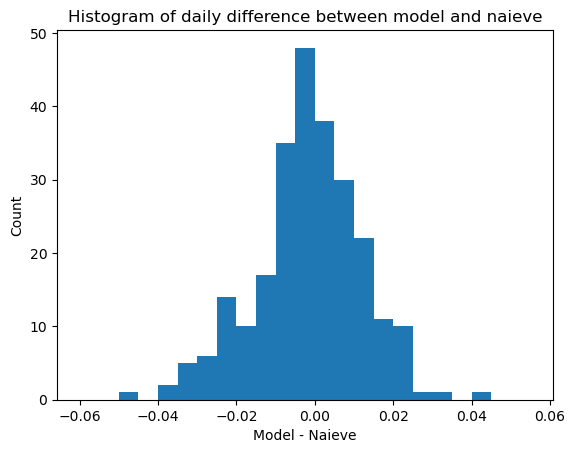

In [24]:
plt.title("Histogram of daily difference between model and naieve")
plt.hist(diff, bins=np.arange(-.06, .06, .005))
plt.xlabel("Model - Naieve")
plt.ylabel("Count")

In [27]:
statistics.mean(diff)

-0.00148967683598462

Text(0, 0.5, 'Count')

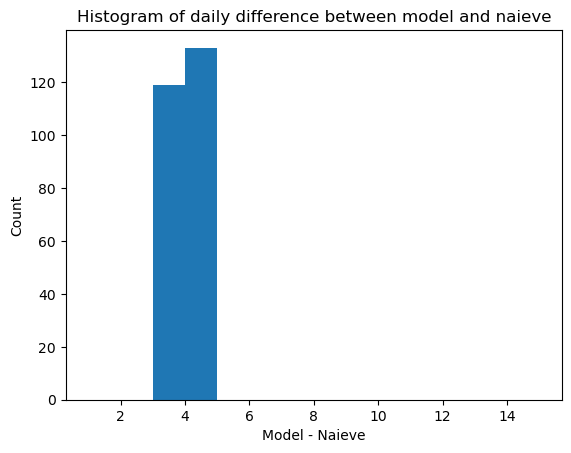

In [28]:
plt.title("Histogram of daily difference between model and naieve")
plt.hist(action_keys, bins=np.arange(1, n_actions))
plt.xlabel("Model - Naieve")
plt.ylabel("Count")

# Takeaways

1) Continuous controll may be needed in this scenario (see deep_continuous_q_learn.ipynb for implementation)

2) Model collapsed to only predciting 4 and 5, this could be because we discritized a continuous action space

3) More info about the past (not just the daily info) may be required. Will try implenting reccurant networks